1. 주제



문체 분석 알고리즘 개발


2. 배경



a. 작가의 글을 분석하여 특징 도출
b. 취향 추천 시스템 활용 / 대필, 유사작 탐지


3. 대회 설명



소설 속 문장뭉치 분석을 통한 저자 예측

A. 데이터 모양

 - train.csv(14MB) : (54879, 3)

 - test_x.csv(10MB) : (19617, 2)

 - sample_submission.csv(1MB) : (19617, 6)



B. 사용된 소설 및 작가 (대회 종료 후 공개)



C. 전처리

 - 비식별화 : 난이도 조절을 위한 비식별화 및 이상치 일부 삽입



D. 평가산식 : logloss



E. 외부 데이터 사용

- 외부 데이터 사용이 불가합니다.

# 데이터 탐색(EDA)

In [11]:
import pandas as pd
import re


train = pd.read_csv('/content/drive/MyDrive/archive (2)/open/train.csv')
sample = pd.read_csv('/content/drive/MyDrive/archive (2)/open/sample_submission.csv')
test = pd.read_csv('/content/drive/MyDrive/archive (2)/open/test_x.csv')

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 데이터 크기 탐색

In [13]:
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


In [14]:
train.isnull().sum()

index     0
text      0
author    0
dtype: int64

In [15]:
sample

,index,0,1,2,3,4
0,0,0,0,0,0,0
1,1,0,0,0,0,0
2,2,0,0,0,0,0
3,3,0,0,0,0,0
4,4,0,0,0,0,0
...,...,...,...,...,...,...
19612,19612,0,0,0,0,0
19613,19613,0,0,0,0,0
19614,19614,0,0,0,0,0
19615,19615,0,0,0,0,0


In [16]:
test

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...
...,...,...
19612,19612,"At the end of another day or two, odin growing..."
19613,19613,"All afternoon we sat together, mostly in silen..."
19614,19614,"odin, having carried his thanks to odin, proc..."
19615,19615,"Soon after this, upon odin's leaving the room,..."


**train data = (54879*3)**

**sample data = (19617*6)**

**test data = (19617*2)**

## 2. 결측값 찾기

In [17]:
train_x, train_y = list(train["text"]), list(train["author"])
test_x, test_i = list(test["text"]), list(test["index"])


In [18]:
for i in range(5):
    print(f"===== example {i} =====")
    print(f"[sentence] : {train_x[i]}")
    print(f"[author] : {train_y[i]}")

===== example 0 =====
[sentence] : He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; looked at odin, and was in evident perplexity.
[author] : 3
===== example 1 =====
[sentence] : “Your sister asked for it, I suppose?”
[author] : 2
===== example 2 =====
[sentence] :  She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by Mr. odin, she saw on looking up that odin was meeting her. Putting away the letter immediately and forcing a smile, she said:
[author] : 1
===== example 3 =====
[sentence] : The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the north side, if you please

In [19]:
for i in range(5):
    print(f"===== example {i} =====")
    print(f"[sentence] : {test_x[i]}")
    print(f"[index] : {test_i[i]}")

===== example 0 =====
[sentence] : “Not at all. I think she is one of the most charming young ladies I ever met, and might have been most useful in such work as we have been doing. She had a decided genius that way: witness the way in which she preserved that Agra plan from all the other papers of her father. But love is an emotional thing, and whatever is emotional is opposed to that true cold reason which I place above all things. I should never marry myself, lest I bias my judgment.”
[index] : 0
===== example 1 =====
[sentence] : "No," replied he, with sudden consciousness, "not to find it in YOU; for I cannot be ignorant that to you, to your goodness, I owe it all.--I feel it--I would express it if I could--but, as you well know, I am no orator."
[index] : 1
===== example 2 =====
[sentence] : As the lady had stated her intention of screaming, of course she would have screamed at this additional boldness, but that the exertion was rendered unnecessary by a hasty knocking at the door


**뒤의 코드는 정규표현식을 사용해 문장 내 영문자와 숫자를 제외한 단어를 공백으로 만들어 제거하려고 함**

In [20]:
#정규표현식을 사용하여 문장 내에 영문자와 숫자를 제외한 단어를 공백으로 치환
def remove_sign(sentence):
    return re.sub(r"[^A-Za-z0-9 ]", " ", sentence)
 
train_x = [remove_sign(sentence) for sentence in train_x]
test_x = [remove_sign(sentence) for sentence in test_x]


In [21]:
# 빈 문장 제거
count = 0
for i in train_x:
    if i.split() == []:
        count += 1
print(f"학습 데이터 중 빈 문장의 갯수 : {count}")
 
count = 0
for i in test_x:
    if i.split() == []:
        count += 1
print(f"테스트 데이터 중 빈 문장의 갯수 : {count}")


학습 데이터 중 빈 문장의 갯수 : 44
테스트 데이터 중 빈 문장의 갯수 : 0


**-> 학습 데이터 중에 정규표현식을 거치니 빈 문장이 44개 존재한다.**

In [22]:
#빈문장 몇 개 제거
def remove_empty(data_x, data_y):
    new_x, new_y = [], []
    for idx, sentence in enumerate(data_x):
        if sentence.split() != []:
            new_x.append(sentence)
            new_y.append(data_y[idx])
    return new_x, new_y
 
train_x, train_y = remove_empty(train_x, train_y)
test_x, test_i = remove_empty(test_x, test_i)
 
print(len(train_x))
print(len(train_y))
print(len(test_x))
print(len(test_i))


54835
54835
19617
19617


## 3. train과 test 문자 길이 분포

**train, test 문자 길이마다 분포**

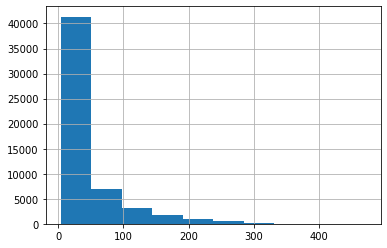

In [23]:
import numpy as np
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

#train 길이마다 갯수
plot_word_number_histogram(train['text'])

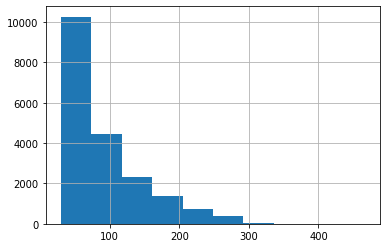

In [24]:
plot_word_number_histogram(test['text'])

**train과 test 문장 길이 비율로 분포 알아보기**

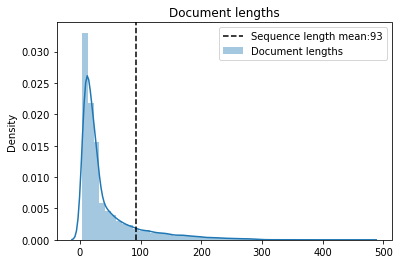

 가장 긴 문장은 471 개의 단어를, 평균 문장은 42.15738260536818 개의 단어를, 가장 짧은 문장은 4 개의 단어를 가지고 있습니다.


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

train['doc_len'] = train.text.apply(lambda words: len(words.split()))

def plot_doc_lengths(dataframe):
    max_seq_len = np.round(dataframe.doc_len.mean() + dataframe.doc_len.std()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=max_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{max_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 평균 문장은 {train['doc_len'].mean()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")
plot_doc_lengths(train)
#평균값은 93이므로 sequence에 적용할 max length를 150 정도로 적당히 잡아준다.

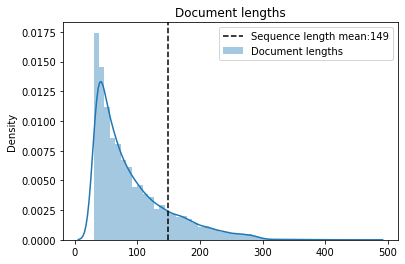

 가장 긴 문장은 471 개의 단어를, 평균 문장은 42.15738260536818 개의 단어를, 가장 짧은 문장은 4 개의 단어를 가지고 있습니다.


In [26]:
test['doc_len'] = test.text.apply(lambda words: len(words.split()))
plot_doc_lengths(test)

In [27]:
train['text_l'] = train['text'].str.lower() 
test['text_l'] = test['text'].str.lower() 

## 4. 작가마다 문장 수/ 불용어 포함&미포함한 작가마다 가장 많은 단어

**작가마다의 문장 수**

author
0    13235
1     7222
2    11554
3    15063
4     7805
dtype: int64

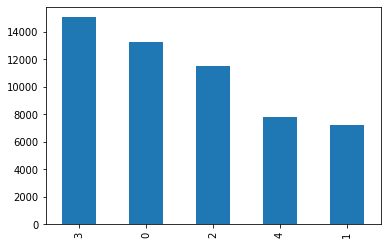

In [28]:
#각 작가마다의 작품 수
train['author'].value_counts().plot(kind='bar')
train.groupby('author').size()

**-> 0이 문장 수가 가장 많고 1이 가장 적다.**

**각 작가마다 불용어 제외하여 많이 분포하는 단어**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


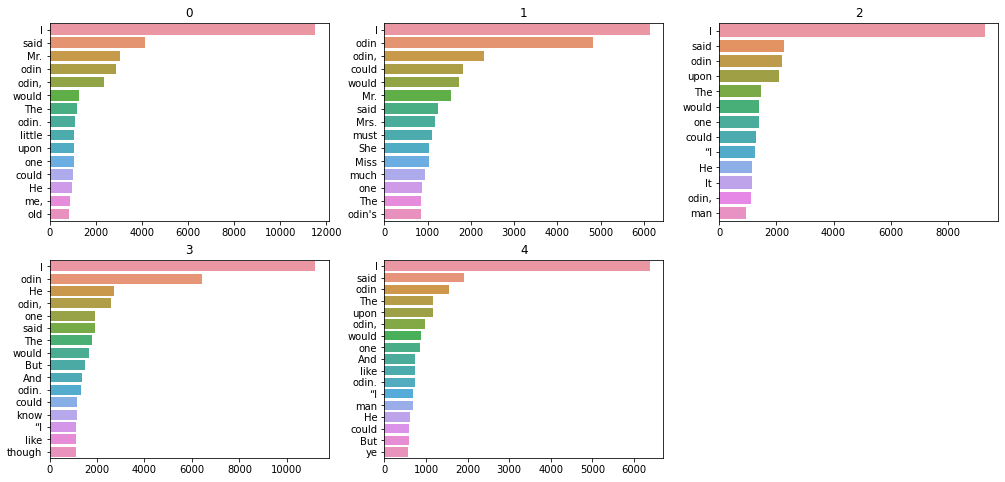

In [29]:
import nltk
from nltk.corpus import stopwords
from collections import  Counter

nltk.download('stopwords')

fig = plt.figure(figsize=(17,8))
rows = 2
cols = 3

def plot_top_non_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    #토큰화 과정
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]


    counter=Counter(corpus)    #출력 결과는 Dictionary형태로 반환
    most=counter.most_common() #most_common은 입력된 값의 요소들 중 빈도수(frequency)가 높은 순으로 상위 n개를 리스트(list) 안의 투플(tuple) 형태로 반환 
                               #most_common에 n을 입력하지 않은 경우, 요소 전체를 [('값', 개수)]의 형태로 반환
    x, y=[], []
    for word,count in most[:70]:
        if (word not in stop): #불용어를 제외한 단어를 찾고 있으므로
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart2(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

**-> 모든 작가는 I가 압도적으로 많고 작가 0,2,4는 2순위로 said/ 작가 1,3의 2순위는 odin이 많다.**

**각 작가마다 불용어가 많이 분포하는 단어**

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


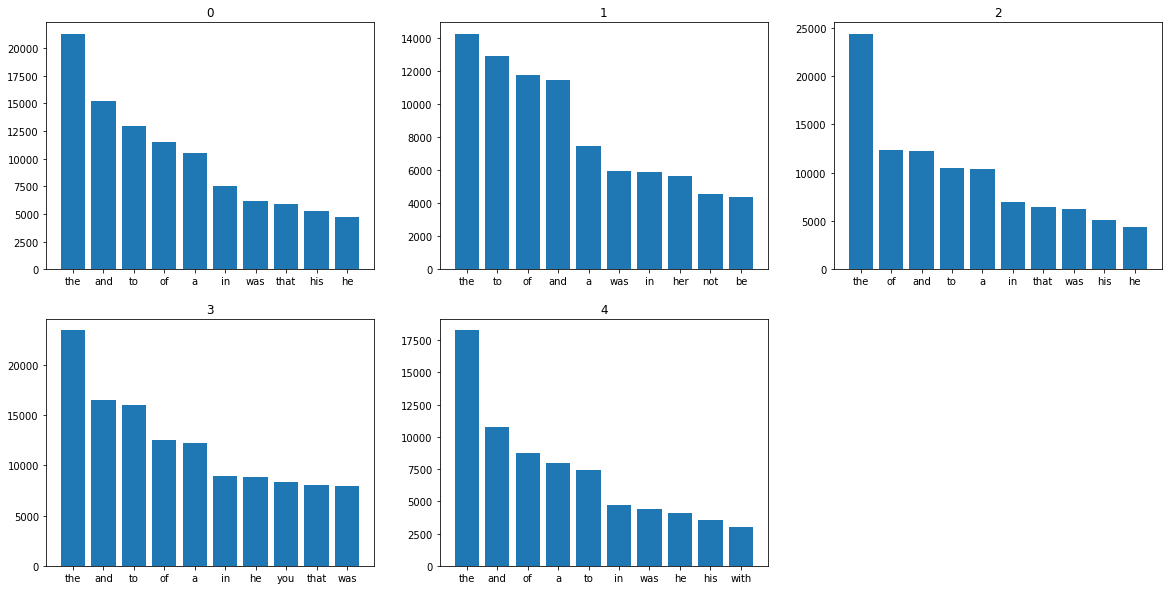

In [30]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int) #dictionary 생성
    for word in corpus:
        if word in stop: #불용어 포함하는지
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] #각 작가당 불용어 많이 쓰는 상위 10개 뽑기 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = plot_top_stopwords_barchart2(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    ax.bar(x,y)

**-> 모든 작가는 불용어 the가 가장 많이 사용하고 작가 1,2를 제외한 모든 작가는 두 번재로 and를 많이 쓴다.**

## 5. 각 작가마다 문장 복잡도/ n-gram

**각 작가마다 문장 복잡도**

In [31]:
!pip install textstat

In [32]:
from textstat import flesch_reading_ease

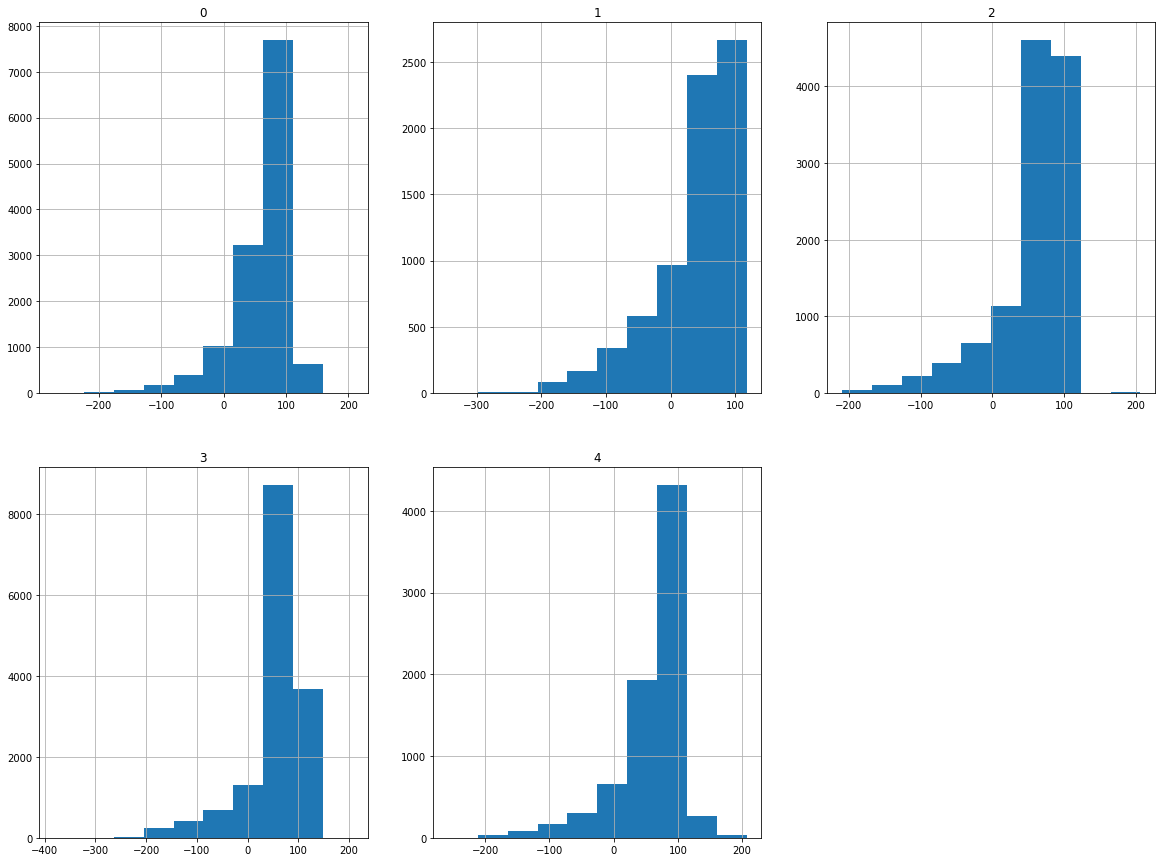

In [33]:
fig = plt.figure(figsize=(20,15)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

for i in range(5):
    text = train[train['author']==i]['text_l'] #소문자 처리ㄴ함
    ax = fig.add_subplot(rows, cols, i+1)
    text.apply(lambda x : flesch_reading_ease(x)).hist().set_title(i) #flesch_reading_ease를 통해 문장의 복잡도 확인
                                                                      # 점수가 높을수록 문장의 복잡도가 낮다.

**작가마다 3-gram**

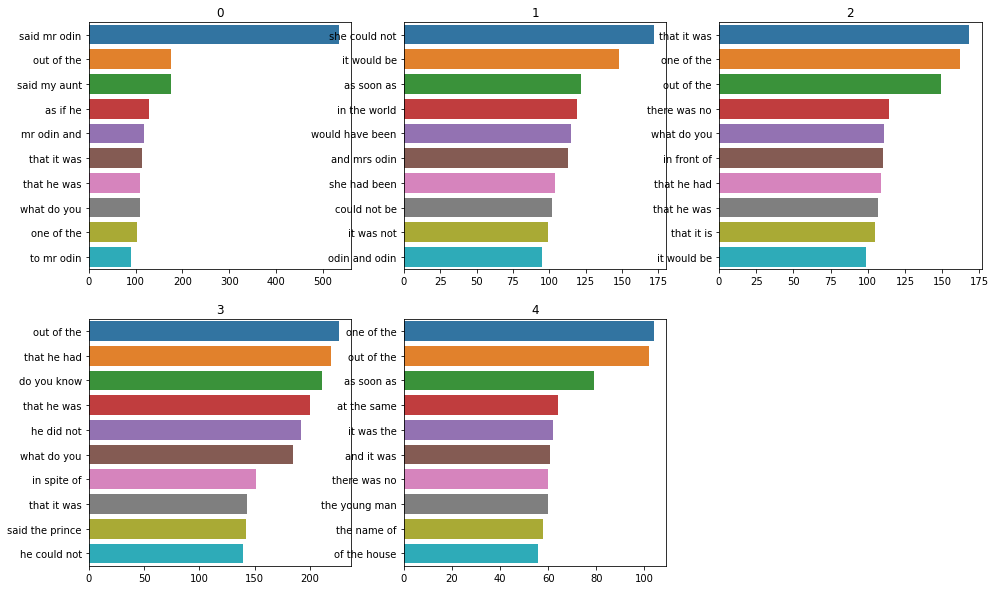

In [34]:
#n-gram
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(16,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_ngrams_barchart2(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        #단어들의 카운트(출현 빈도(frequency))로 여러 문서들을 벡터화 
        #카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
        #모두 소문자로 변환시키기 때문에 me 와 Me 는 모두 같은 특성
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10] # 상위 10개까지

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    
    return x, y

for i in range(5):
    x,y = plot_top_ngrams_barchart2(train[train['author']==i]['text'], n=3)
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)   
#작가마다 제일 많이 쓰이느 3-gram

**-> out of the 구문이 작가 0,2,3,4에게 많이 사용되고 one of the가 작가 2,4에게 많이 사용되며 이 두 개 구문이 작가1에게는 상위 10개 안에 들지 않는다.**

**전체 작가 3-gram**

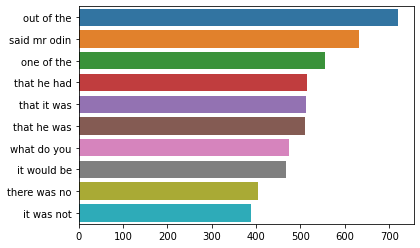

In [35]:
x,y=plot_top_ngrams_barchart2(train['text'], n=3)
sns.barplot(x=y,y=x)  

## 6. 작가마다 LDA

작가마다의 Topic keyword 추출하기

In [36]:
!pip install pyLDAvis

In [37]:
!pip install pyLDAvis.gensim

ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim


In [38]:
# With NLTK you can tokenize and lemmatize easily:

import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
import pyLDAvis
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models as gensimvis

NUM_TOPICS = 5 # 차원 5개를 뽑겠다.

def get_lda_objects(text):
    nltk.download('stopwords')    
    stop=set(stopwords.words('english')) #불용어 정의

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer() #어간 추출 알고리즘(마치 토큰화)
        lem=WordNetLemmatizer() #표제어 추출을 위한 도구
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)] #불용어가 아닌 문장을 가지고 토큰화

            words=[lem.lemmatize(w) for w in words if len(w)>2] #문장 길이가 2는 넘어야 된다.

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus] #doc2bow method는 단어의 id와 빈도수를 추출해준다.
    
    #사전 훈련 된 주제 모델을 사용
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = NUM_TOPICS, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, bow_corpus, dic) #학습된 LDA 모델로부터 추출된 정보를 가지고 시각화해주는 내장 저장된 prerpare함수
    return vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [39]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [40]:
import nltk

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [41]:
lda_model, bow_corpus, dic = get_lda_objects(train['text_l'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(El

In [42]:
lda_model.show_topics()

[(0,
  '0.039*"odin" + 0.031*"said" + 0.021*"mr." + 0.010*"sir" + 0.010*"man" + 0.007*"upon" + 0.007*"one" + 0.006*"may" + 0.006*"would" + 0.006*"dear"'),
 (1,
  '0.042*"odin" + 0.012*"face" + 0.012*"hand" + 0.011*"eye" + 0.009*"looked" + 0.008*"upon" + 0.007*"door" + 0.007*"room" + 0.006*"back" + 0.006*"moment"'),
 (2,
  '0.011*"upon" + 0.010*"one" + 0.006*"two" + 0.006*"night" + 0.005*"little" + 0.005*"day" + 0.005*"great" + 0.005*"house" + 0.005*"like" + 0.005*"man"'),
 (3,
  '0.048*"odin" + 0.012*"would" + 0.011*"could" + 0.008*"mr." + 0.007*"much" + 0.006*"one" + 0.006*"said" + 0.006*"time" + 0.005*"must" + 0.005*"mrs."'),
 (4,
  '0.042*"odin" + 0.034*"said" + 0.017*"know" + 0.016*"..." + 0.013*"come" + 0.012*"say" + 0.011*"cried" + 0.011*"n\'t" + 0.010*"see" + 0.010*"well"')]

In [43]:
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.070888 -0.018333       1        1  32.833552
1      0.173662 -0.167639       2        1  19.411690
2      0.196208  0.159241       3        1  17.486641
4     -0.157511 -0.021826       4        1  17.068275
0     -0.141471  0.048556       5        1  13.199842, topic_info=     Term          Freq         Total Category  logprob  loglift
40   said  12894.000000  12894.000000  Default  30.0000  30.0000
13   odin  38354.000000  38354.000000  Default  29.0000  29.0000
34    mr.   5866.000000   5866.000000  Default  28.0000  28.0000
74    ...   2830.000000   2830.000000  Default  27.0000  27.0000
455  know   4721.000000   4721.000000  Default  26.0000  26.0000
..    ...           ...           ...      ...      ...      ...
16    say    664.039518   3883.799097   Topic5  -5.3493   0.2587
320   old    574.337691   2529.416879   Topic5  -5.4944   0.5424
800  good    592.706864   2995.111220   Topic5  -5.4630   0.4049
268  come    514.142136   4023.671812   Topic5  -5.6052  -0.0325
138   yet    481.517293   1740.478536   Topic5  -5.6707   0.7400

[423 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
936       5  0.996638     'and
4750      4  0.989093      'em
4323      4  0.989412      'he
741       4  0.999586      'll
4783      5  0.987976      'no
...     ...       ...      ...
138       2  0.085609      yet
138       3  0.222353      yet
138       4  0.091929      yet
138       5  0.276935      yet
1293      4  0.981979  zametov

[890 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 5, 1])

**-> 한 군집말고는 대부분이 odin이라는 단어가 많이 띄는 것을 확인 할 수 있다.**

## 7. 작가마다 특수 문자 빈도 수(분포)

**작가마다 특수 기호 분포**

<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<ipython-input-44-adb5c7acb13b>:15: DeprecationWarning: invalid escape sequence \?
  corpus=[re.sub('[^-=+,#/\?:^$.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


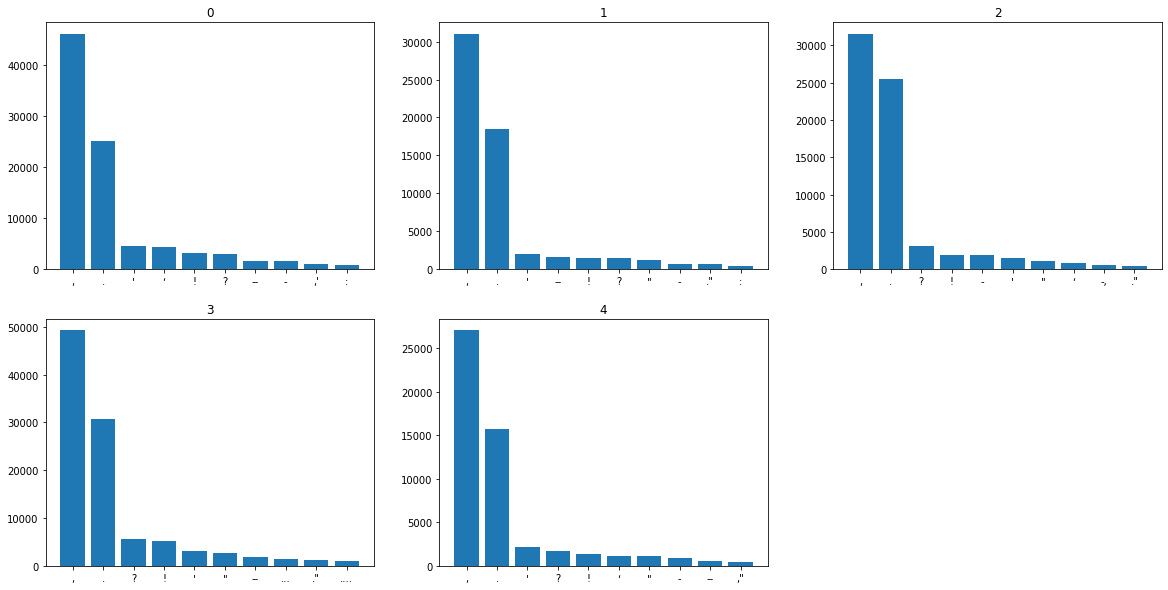

In [44]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    new= text.str.split()
    new=new.values.tolist()

    corpus=[re.sub('[^-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i] #정규화를 통한 특수문자가 아니면 제거
    
    corpus = [v for v in corpus if v] #빈 문자열 제거
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
      dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]  #상위 10개 추출
    x,y=zip(*top)
    return x, y

for i in range(5):
  x,y = plot_top_stopwords_barchart2(train[train['author']==i]['text'])
  ax = fig.add_subplot(rows, cols, i+1)
  ax.set_title(i)
  ax.bar(x,y)

**-> 모든 작가들이 많이 쓰는 특수문자는 ','와 '.'을 많이 사용하는 것을 알 수 있다.**

**전체 특수문자 분포**

<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<input>:15: DeprecationWarning: invalid escape sequence \?
<ipython-input-45-16c665f2aba8>:15: DeprecationWarning: invalid escape sequence \?
  corpus=[re.sub('[^-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new fo

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

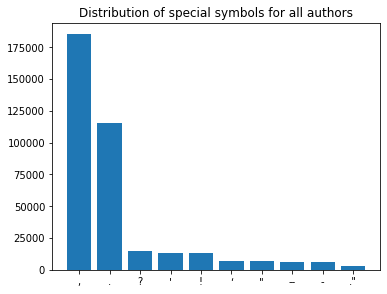

In [45]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

fig = plt.figure(figsize=(20,10))
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    new= text.str.split()  #잘라서 list화 시키기
    new=new.values.tolist()
    
    corpus=[re.sub('[^-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i] #정규화를 통한 특수문자가 아니면 제거
    
    corpus = [v for v in corpus if v] #빈 문자열 제거
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
      dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    return x, y
x,y = plot_top_stopwords_barchart2(train['text'])
ax = fig.add_subplot(rows, cols, 1)
ax.set_title("Distribution of special symbols for all authors")
ax.bar(x,y)

**-> 위에서 확인했듯이 압도적으로 ','과 '.'을 많이 사용하는 것을 알 수 있다.**

## 8. TF-IDF Score Top 100 단어 시각화

TF-IDF를 사용하여 단어의 중요도를 산출하였고, 선택된 100개의 단어를 t-SNE로 시각화 하였다. t-SNE는 고차원상에 존재하는 데이터의 유사성들을 KL-divergence가 최소화되도록 저차원(2차원)으로 임베딩시키는 방법이다.

In [46]:
# 특수문자 제거.
def alpha_num(text):
  text =  re.sub(r'[^A-Za-z0-9\s]', '', text)
  return text

train['text'] = train['text'].apply(alpha_num)

In [47]:
train

,index,text,author,doc_len,text_l
0,0,He was almost choking There was so much so muc...,3,46,"he was almost choking. there was so much, so m..."
1,1,Your sister asked for it I suppose,2,7,"“your sister asked for it, i suppose?”"
2,2,She was engaged one day as she walked in peru...,1,57,"she was engaged one day as she walked, in per..."
3,3,The captain was in the porch keeping himself c...,4,58,"the captain was in the porch, keeping himself ..."
4,4,Have mercy gentlemen odin flung up his hands D...,3,39,"“have mercy, gentlemen!” odin flung up his han..."
...,...,...,...,...,...
54874,54874,Is that you Mr Smith odin whispered I hardly d...,2,15,"“is that you, mr. smith?” odin whispered. “i h..."
54875,54875,I told my plan to the captain and between us w...,4,18,"i told my plan to the captain, and between us ..."
54876,54876,Your sincere wellwisher friend and sister LUC...,1,8,"""your sincere well-wisher, friend, and sister..."
54877,54877,Then you wanted me to lend you money,3,8,“then you wanted me to lend you money?”


In [48]:
# 불용어 처리
def remove_stopwords(text):
  final_text = []
  for i in text.split():
    if i.strip().lower() not in stopwords:
      final_text.append(i.strip())
  return " ".join(final_text)

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [49]:
# 소문자 변환, 기호 제거, 불용어 처리
train['text'] = train['text'].str.lower()
test['text'] = train['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

### 1. 모든 작가 통틀어서 TF-IDF Score Top 100

<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence \?
<input>:20: DeprecationWarning: invalid escape sequence 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.018s...
[t-SNE] Computed neighbors for 100 samples in 0.181s...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 6.047286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 116.911659


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 2500 iterations: 0.899778
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.014s...
[t-SNE] Computed neighbors for 100 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 5.240595


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.732903


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 3150 iterations: 0.910635
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.015s...
[t-SNE] Computed neighbors for 100 samples in 0.174s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 4.557215


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.856316


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1350 iterations: 0.791468
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.022s...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


[t-SNE] Computed neighbors for 100 samples in 0.244s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 6.580809
[t-SNE] KL divergence after 250 iterations with early exaggeration: 99.175858


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/

[t-SNE] KL divergence after 1950 iterations: 0.916493
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.011s...
[t-SNE] Computed neighbors for 100 samples in 0.117s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 4.838464


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.014709


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1850 iterations: 0.893628


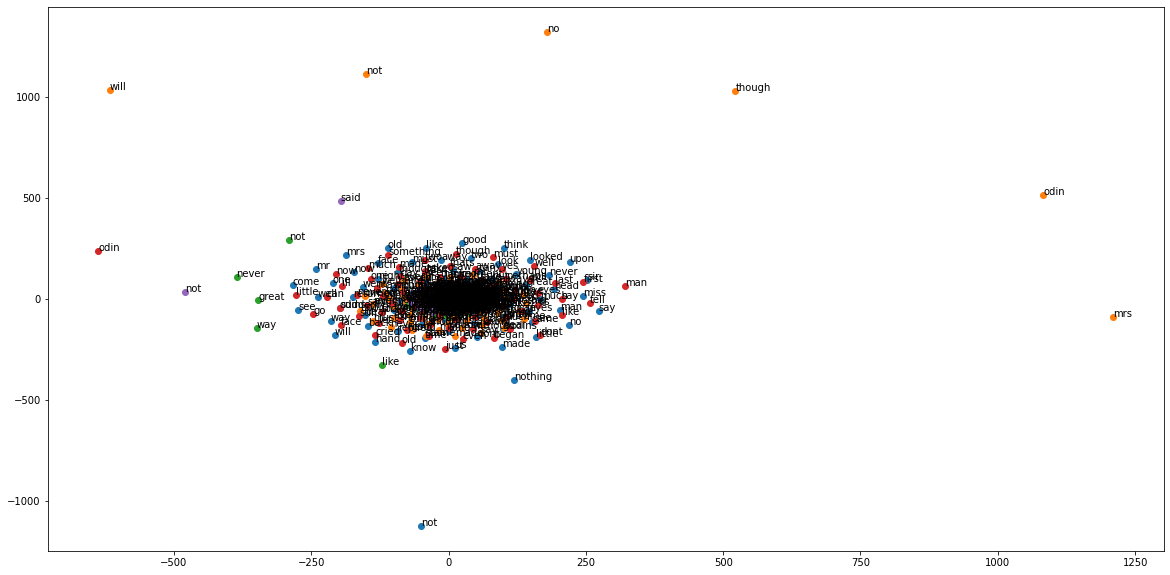

In [50]:
#출처: https://donghwa-kim.github.io/TFIDF.html
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    new= text.str.split()
    new=new.values.tolist()
    
    corpus=[re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i] #정규화를 통한 특수문자가 아니면 제거
    #빈 문자열 제거
    corpus = [v for v in corpus if v]

    tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0) #Top100개까지 뽑기
    
    #generate tf-idf term-document matrix
    A_tfidf_sp = tfidf.fit_transform(corpus)  #size D x V
    tfidf_dict = tfidf.get_feature_names() #100개 이름

    data_array = A_tfidf_sp.toarray()
    data = pd.DataFrame(data_array, columns=tfidf_dict)
    
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1) #단어 간의 친밀도를 보기 위해서!(2차원으로 확인하려 한다.)

    Z = tsne.fit_transform(data_array.T)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
      plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    plt.draw()

for i in range(5):
  plot_top_stopwords_barchart2(train[train['author']==i]['text'])

### author_0 중요 단어 그룹화

<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence 

author 0 tf-idf
단어 빈도 많은 순으로 정렬
['odin', 'said', 'mr', 'not', 'no', 'one', 'little', 'upon', 'know', 'now', 'old', 'time', 'miss', 'man', 'come', 'dont', 'well', 'say', 'will', 'dear', 'much', 'never', 'like', 'made', 'see', 'think', 'hand', 'good', 'head', 'mrs', 'odins', 'replied', 'sir', 'looked', 'us', 'way', 'go', 'went', 'face', 'back', 'two', 'came', 'young', 'long', 'away', 'returned', 'eyes', 'great', 'might', 'look', 'looking', 'thought', 'must', 'nothing', 'aunt', 'night', 'can', 'first', 'may', 'boy', 'joe', 'ever', 'saw', 'took', 'day', 'take', 'going', 'put', 'another', 'got', 'asked', 'quite', 'without', 'door', 'mind', 'done', 'yes', 'oh', 'last', 'room', 'tell', 'make', 'life', 'gentleman', 'house', 'off', 'cried', 'hands', 'always', 'still', 'shall', 'doctor', 'better', 'let', 'even', 'round', 'sat', 'home', 'left', 'place', 'knew', 'many', 'mother', 'though', 'every', 'something', 'anything', 'seen', 'told', 'seemed', 'name', 'heart', 'dora', 'yet', 'found', 'ill', '

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 6.047286
[t-SNE] KL divergence after 250 iterations with early exaggeration: 118.529427


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/

[t-SNE] KL divergence after 2300 iterations: 0.893047


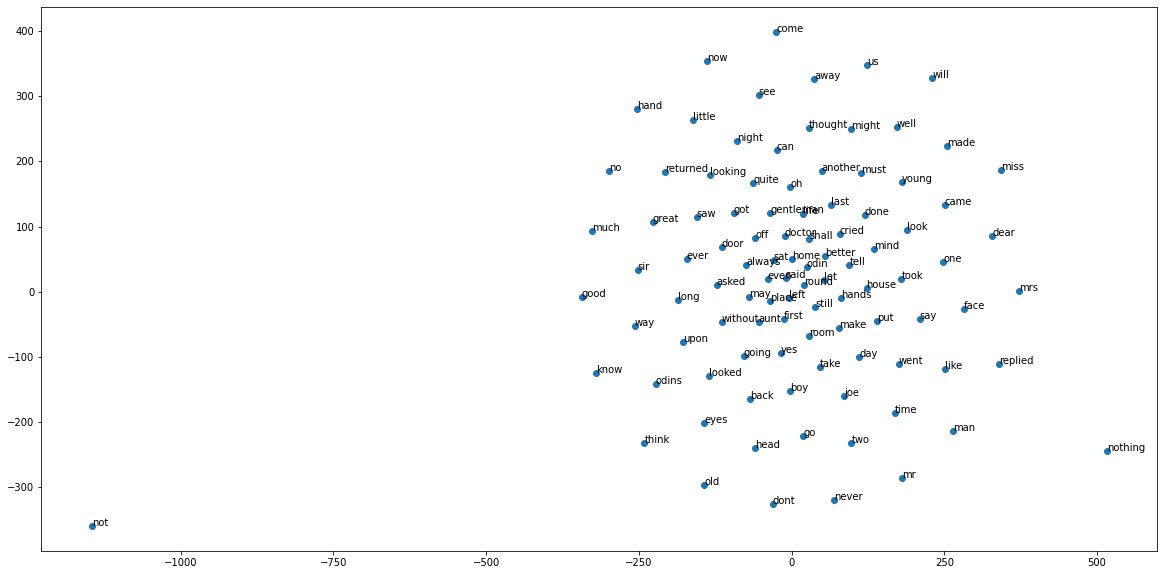

In [51]:
#출처: https://donghwa-kim.github.io/TFIDF.html
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    #stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    #documents = [' '.join(i[0].split(' ')[1:]) for i in article_data.values]
    #정규화를 통한 특수문자가 아니면 제거
    corpus=[re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i]
    #빈 문자열 제거
    corpus = [v for v in corpus if v]
    #print(corpus[1])
    count=Counter(corpus)
    vocab = sorted(count, key=count.get, reverse=True)
    print("단어 빈도 많은 순으로 정렬")
    print(vocab)
    tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)
    
    #generate tf-idf term-document matrix
    A_tfidf_sp = tfidf.fit_transform(corpus)  #size D x V
    tfidf_dict = tfidf.get_feature_names()

    data_array = A_tfidf_sp.toarray()
    data = pd.DataFrame(data_array, columns=tfidf_dict)
    #단어 간의 친밀도를 보기 위해서!
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

    Z = tsne.fit_transform(data_array.T)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
      plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    plt.draw()

print("author 0 tf-idf")
plot_top_stopwords_barchart2(train[train['author']==0]['text'])

**-> 많은 빈도를 보이는 odin 단어를 기준으로 단어들이 모여있는 것을 확인할 수 있다.**

### author_1 중요 단어 그룹화

<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence 

author 1 tf-idf
단어 빈도 많은 순으로 정렬
['odin', 'not', 'no', 'mr', 'said', 'will', 'mrs', 'odins', 'must', 'miss', 'one', 'much', 'think', 'well', 'now', 'know', 'every', 'little', 'never', 'time', 'can', 'might', 'good', 'nothing', 'may', 'say', 'without', 'see', 'soon', 'great', 'though', 'shall', 'first', 'two', 'man', 'quite', 'dear', 'thought', 'ever', 'upon', 'young', 'always', 'sir', 'made', 'lady', 'like', 'sure', 'make', 'thing', 'long', 'go', 'give', 'sister', 'day', 'away', 'many', 'last', 'come', 'however', 'house', 'way', 'hope', 'indeed', 'us', 'even', 'better', 'room', 'friend', 'cannot', 'enough', 'just', 'oh', 'saw', 'mind', 'felt', 'jane', 'father', 'cried', 'came', 'done', 'moment', 'seemed', 'something', 'family', 'still', 'look', 'wish', 'happy', 'rather', 'yes', 'really', 'perhaps', 'mother', 'home', 'heard', 'another', 'morning', 'looked', 'going', 'take', 'heart', 'believe', 'feelings', 'pleasure', 'found', 'replied', 'till', 'yet', 'love', 'part', 'place', 'letter', '

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.407913


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1250 iterations: 0.916366


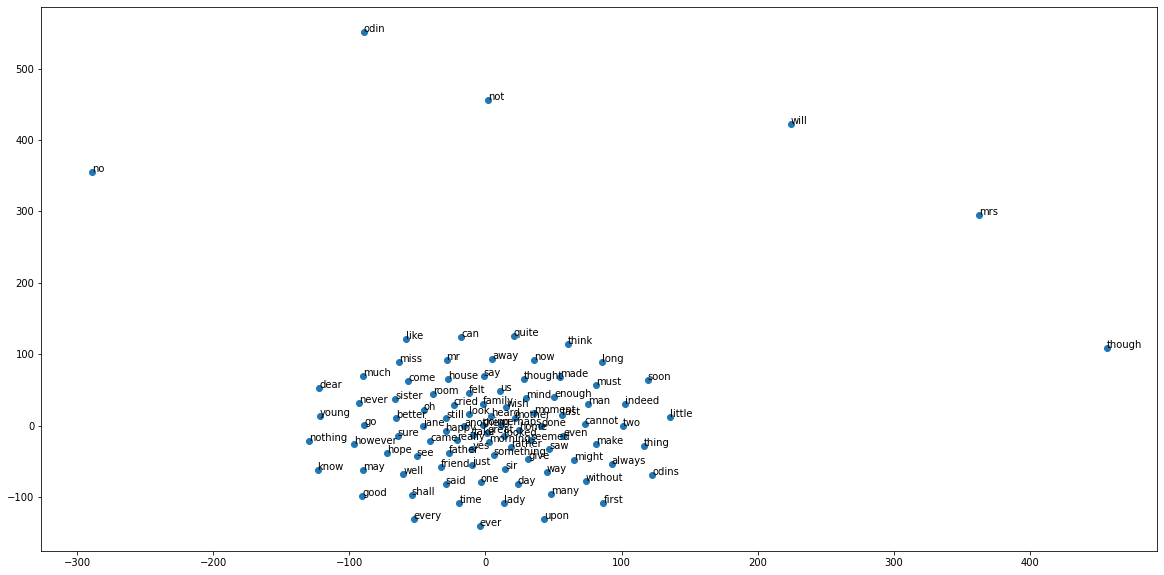

In [52]:
#출처: https://donghwa-kim.github.io/TFIDF.html
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    #stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    #documents = [' '.join(i[0].split(' ')[1:]) for i in article_data.values]
    #정규화를 통한 특수문자가 아니면 제거
    corpus=[re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i]
    #빈 문자열 제거
    corpus = [v for v in corpus if v]
    #print(corpus[1])
    count=Counter(corpus)
    vocab = sorted(count, key=count.get, reverse=True)
    print("단어 빈도 많은 순으로 정렬")
    print(vocab)
    tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)
    
    #generate tf-idf term-document matrix
    A_tfidf_sp = tfidf.fit_transform(corpus)  #size D x V
    tfidf_dict = tfidf.get_feature_names()

    data_array = A_tfidf_sp.toarray()
    data = pd.DataFrame(data_array, columns=tfidf_dict)
    #단어 간의 친밀도를 보기 위해서!
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

    Z = tsne.fit_transform(data_array.T)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
      plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    plt.draw()

print("author 1 tf-idf")
plot_top_stopwords_barchart2(train[train['author']==1]['text'])

**-> author 1은 author 0과 달리 odin 단어가 다른 단어와 관계가 먼 것을 알 수 있다.**

### author_2 중요 단어 그룹화

<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence 

author 2 tf-idf
단어 빈도 많은 순으로 정렬
['odin', 'said', 'not', 'upon', 'one', 'no', 'man', 'will', 'us', 'sir', 'see', 'now', 'can', 'well', 'may', 'come', 'mr', 'little', 'cried', 'two', 'came', 'know', 'back', 'time', 'face', 'must', 'think', 'never', 'great', 'like', 'might', 'way', 'say', 'hand', 'good', 'asked', 'long', 'last', 'shall', 'eyes', 'yet', 'old', 'room', 'made', 'much', 'heard', 'door', 'house', 'nothing', 'away', 'still', 'go', 'first', 'saw', 'night', 'found', 'left', 'round', 'thought', 'every', 'tell', 'head', 'take', 'make', 'ever', 'off', 'side', 'get', 'day', 'yes', 'just', 'three', 'lord', 'matter', 'young', 'case', 'however', 'seen', 'life', 'took', 'small', 'done', 'black', 'far', 'men', 'hands', 'light', 'right', 'without', 'friend', 'let', 'even', 'something', 'give', 'dont', 'find', 'end', 'looked', 'answered', 'odins', 'lady', 'many', 'morning', 'look', 'name', 'mind', 'lay', 'put', 'though', 'behind', 'enough', 'seemed', 'thing', 'turned', 'dr', 'went', 'got', 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.184929


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1250 iterations: 0.808692


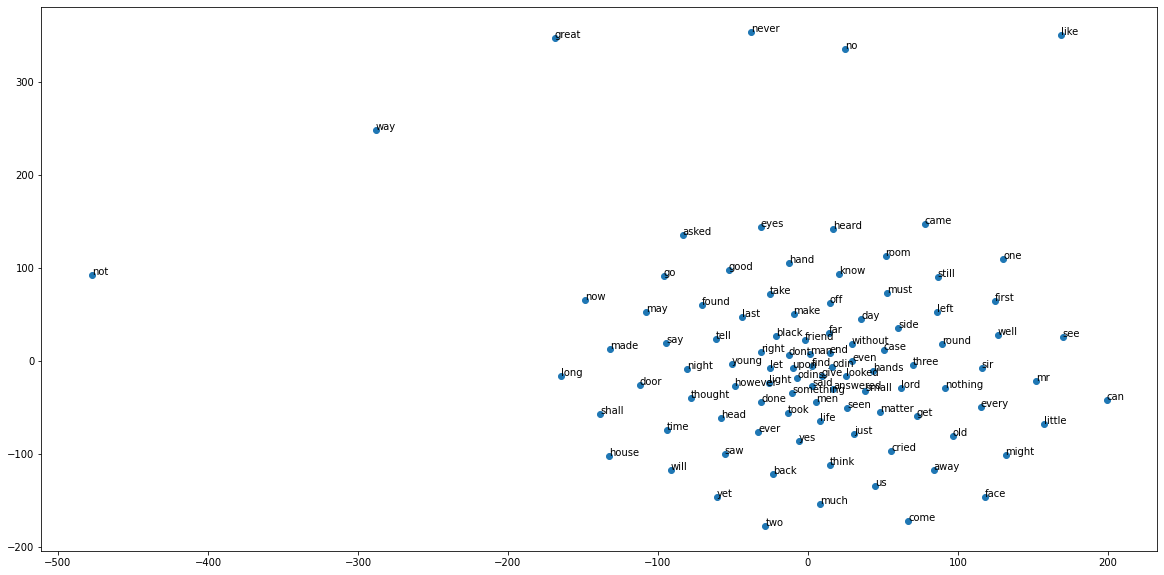

In [53]:
#출처: https://donghwa-kim.github.io/TFIDF.html
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    #stop=set(stopwords.words('english'))
    new= text.str.split()
    new=new.values.tolist()
    #documents = [' '.join(i[0].split(' ')[1:]) for i in article_data.values]
    #정규화를 통한 특수문자가 아니면 제거
    corpus=[re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i]
    #빈 문자열 제거
    corpus = [v for v in corpus if v]
    #print(corpus[1])
    count=Counter(corpus)
    vocab = sorted(count, key=count.get, reverse=True)
    print("단어 빈도 많은 순으로 정렬")
    print(vocab)
    tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)
    
    #generate tf-idf term-document matrix
    A_tfidf_sp = tfidf.fit_transform(corpus)  #size D x V
    tfidf_dict = tfidf.get_feature_names()

    data_array = A_tfidf_sp.toarray()
    data = pd.DataFrame(data_array, columns=tfidf_dict)
    #단어 간의 친밀도를 보기 위해서!
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

    Z = tsne.fit_transform(data_array.T)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
      plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    plt.draw()

print("author 2 tf-idf")
plot_top_stopwords_barchart2(train[train['author']==2]['text'])

**-> author 0과 유사하게 author 2도 가장 빈도수가 높은 odin을 기준으로 단어들이 밀집되어 있다.**

### author_3 중요 단어 그룹화

<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence 

author 3 tf-idf
단어 빈도 많은 순으로 정렬
['odin', 'not', 'one', 'said', 'no', 'will', 'know', 'now', 'dont', 'come', 'though', 'like', 'man', 'prince', 'time', 'go', 'see', 'even', 'say', 'suddenly', 'well', 'odins', 'cried', 'must', 'just', 'thats', 'last', 'can', 'nothing', 'something', 'tell', 'thought', 'little', 'went', 'away', 'shall', 'face', 'asked', 'never', 'ill', 'without', 'perhaps', 'eyes', 'first', 'much', 'began', 'old', 'off', 'oh', 'yes', 'us', 'looked', 'think', 'still', 'moment', 'made', 'way', 'two', 'came', 'quite', 'good', 'day', 'may', 'every', 'take', 'course', 'let', 'make', 'almost', 'three', 'people', 'ive', 'back', 'room', 'look', 'long', 'great', 'believe', 'another', 'father', 'put', 'told', 'going', 'get', 'understand', 'right', 'love', 'money', 'life', 'seemed', 'upon', 'hand', 'give', 'house', 'want', 'always', 'might', 'heard', 'heart', 'ivan', 'word', 'really', 'whole', 'woman', 'took', 'anything', 'everything', 'looking', 'turned', 'yet', 'mind', 'door', 'won

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


[t-SNE] Computed neighbors for 100 samples in 0.258s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 6.580809


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 250 iterations with early exaggeration: 110.177155


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 2550 iterations: 0.899558


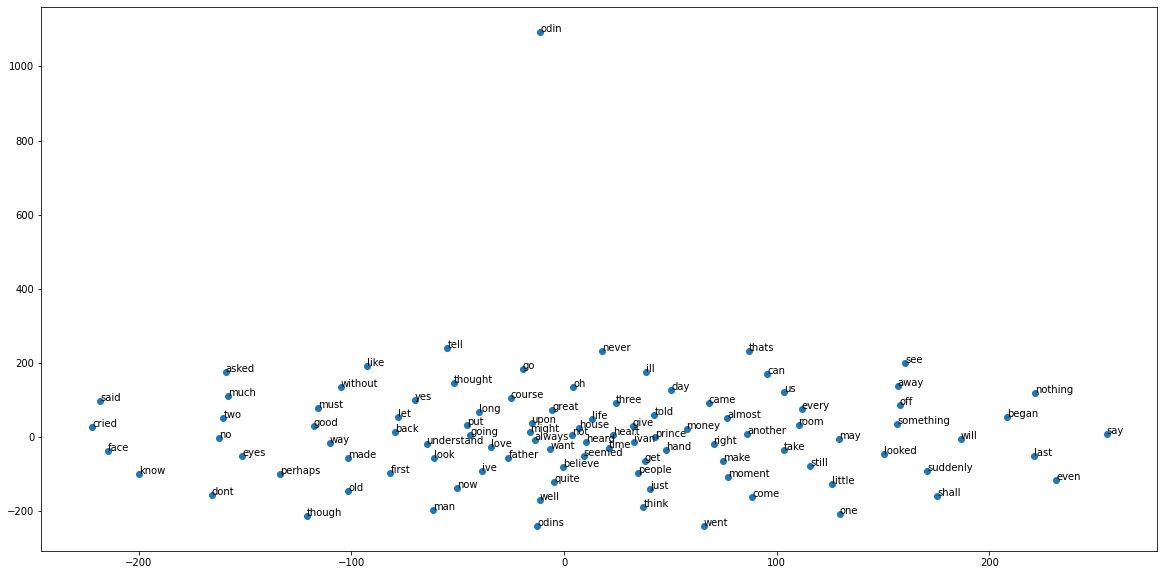

In [54]:
#출처: https://donghwa-kim.github.io/TFIDF.html
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):

    new= text.str.split()
    new=new.values.tolist()

    #정규화를 통한 특수문자가 아니면 제거
    corpus=[re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i]
    #빈 문자열 제거
    corpus = [v for v in corpus if v]
    
    count=Counter(corpus)
    vocab = sorted(count, key=count.get, reverse=True)
    print("단어 빈도 많은 순으로 정렬")
    print(vocab)
    tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)
    
    #generate tf-idf term-document matrix
    A_tfidf_sp = tfidf.fit_transform(corpus)  #size D x V
    tfidf_dict = tfidf.get_feature_names()

    data_array = A_tfidf_sp.toarray()
    data = pd.DataFrame(data_array, columns=tfidf_dict)
    #단어 간의 친밀도를 보기 위해서!
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

    Z = tsne.fit_transform(data_array.T)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
      plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    plt.draw()

print("author 3 tf-idf")
plot_top_stopwords_barchart2(train[train['author']==3]['text'])

**-> author3은 author1과 유사하게 가장 많은 분포를 가진 odin이 다른 단어와 관계가 먼 것을 알 수 있다.**

### author_4 중요 단어 그룹화

<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence \?
<input>:22: DeprecationWarning: invalid escape sequence 

author 4 tf-idf
단어 빈도 많은 순으로 정렬
['odin', 'said', 'not', 'upon', 'no', 'man', 'one', 'will', 'now', 'like', 'ye', 'cried', 'well', 'sir', 'mr', 'little', 'good', 'time', 'see', 'hand', 'still', 'us', 'come', 'must', 'came', 'great', 'returned', 'two', 'house', 'back', 'know', 'last', 'made', 'never', 'think', 'thought', 'yet', 'replied', 'can', 'go', 'much', 'began', 'first', 'say', 'shall', 'even', 'old', 'may', 'lord', 'face', 'asked', 'says', 'long', 'looked', 'way', 'men', 'master', 'prince', 'doctor', 'eyes', 'odins', 'take', 'night', 'life', 'word', 'let', 'day', 'door', 'might', 'another', 'went', 'hands', 'head', 'indeed', 'mind', 'name', 'heart', 'side', 'captain', 'seemed', 'make', 'set', 'lay', 'without', 'young', 'took', 'nothing', 'turned', 'moment', 'look', 'away', 'place', 'open', 'among', 'tell', 'enough', 'saw', 'many', 'off', 'sure', 'thing', 'heard', 'put', 'ill', 'right', 'part', 'left', 'give', 'voice', 'far', 'o', 'found', 'soon', 'better', 'poor', 'stood', 'perhap

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: D

[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.288239


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:348: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] KL divergence after 1750 iterations: 0.929376


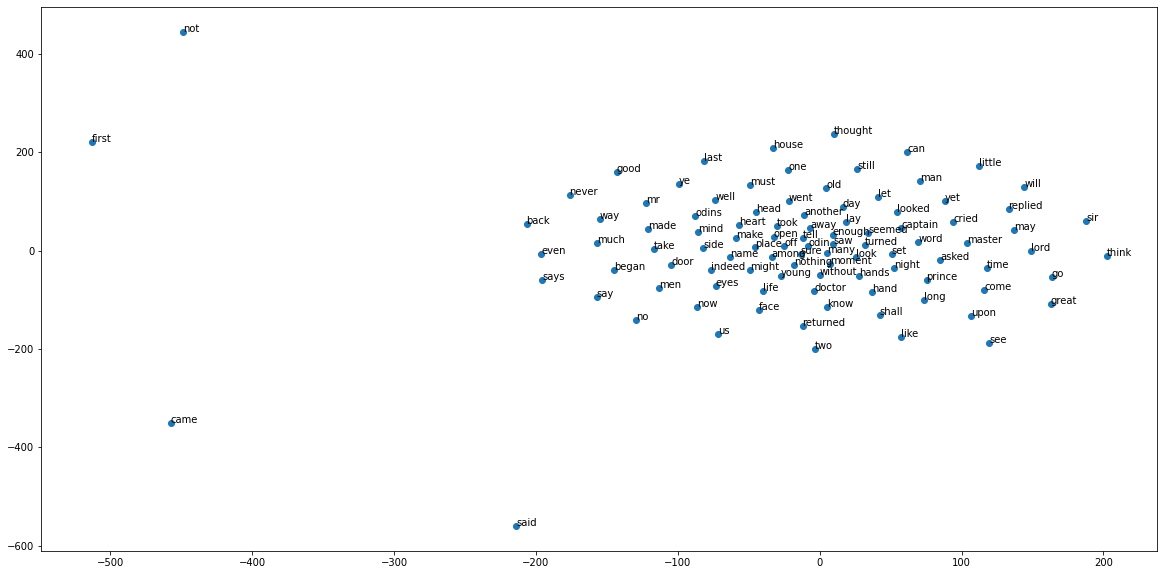

In [55]:
#출처: https://donghwa-kim.github.io/TFIDF.html
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):

    new= text.str.split()
    new=new.values.tolist()

    #정규화를 통한 특수문자가 아니면 제거
    corpus=[re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]','',word) for i in new for word in i]
    #빈 문자열 제거
    corpus = [v for v in corpus if v]
    
    count=Counter(corpus)
    vocab = sorted(count, key=count.get, reverse=True)
    print("단어 빈도 많은 순으로 정렬")
    print(vocab)
    tfidf = TfidfVectorizer(max_features = 100, max_df=0.95, min_df=0)
    
    #generate tf-idf term-document matrix
    A_tfidf_sp = tfidf.fit_transform(corpus)  #size D x V
    tfidf_dict = tfidf.get_feature_names()

    data_array = A_tfidf_sp.toarray()
    data = pd.DataFrame(data_array, columns=tfidf_dict)
    #단어 간의 친밀도를 보기 위해서!
    tsne = TSNE(n_components=2, n_iter=10000, verbose=1)

    Z = tsne.fit_transform(data_array.T)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(len(tfidf_dict)):
      plt.annotate(s=tfidf_dict[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    plt.draw()

print("author 4 tf-idf")
plot_top_stopwords_barchart2(train[train['author']==4]['text'])

**-> author 4는 author 0, author 2와 유사하가 가장 많은 빈도를 가진 단어인 odin을 중심으로 단어들이 밀집되어 있다.**

In [58]:
print(test_x)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [59]:
X_train = train['text'].values
Y_train = train['author'].values

X_test = test['text'].values
print(X_train.shape, X_test.shape, Y_train.shape)

(54879,) (19617,) (54879,)
